In [82]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import scale
from scipy.stats import skew, skewtest
%config InlineBackend.figure_format = 'png' 
%matplotlib inline

In [206]:
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")

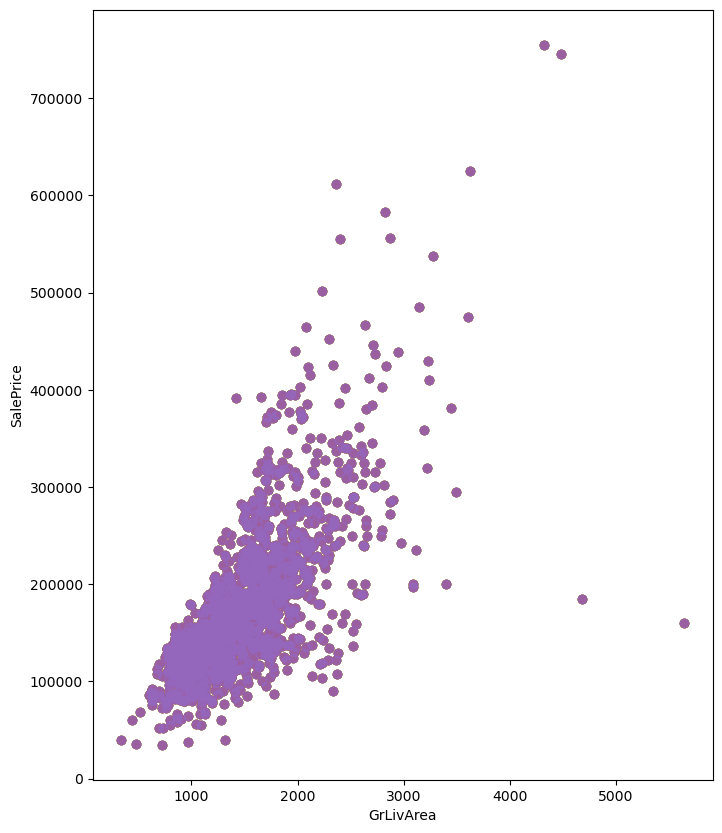

In [224]:

sns.regplot(data=train, x="GrLivArea", y="SalePrice", fit_reg=False)
# sns.title("Living Area vs SalePrice (training set)")
plt.show()

In [226]:
# Boolean mask for the “obvious” outliers
mask = (train['GrLivArea'] > 4000) & (train['SalePrice'] < 300000)

# Check which rows you are about to drop
train.loc[mask, ['Id', 'GrLivArea', 'SalePrice']]

train = train.drop(train[mask].index).reset_index(drop=True)

In [228]:
for df in (train, test):
    df['1_2_Floor_SF'] = df['1stFlrSF'] + df['2ndFlrSF']
    df['Living_Area'] = df['1_2_Floor_SF'] + df['LowQualFinSF'] + df['GarageArea']

categorical_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = train.select_dtypes(include=['number']).columns.tolist()
print(numerical_cols)

['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice', '1_2_Floor_SF', 'Living_Area']


In [230]:
feats = train.columns.difference(['Id', 'SalePrice'])

all_data = pd.concat((
    train.loc[:, feats],
    test.loc[:, feats]
))

In [232]:
numeric_feats = numerical_cols.copy()
numeric_feats.remove('SalePrice')
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [234]:
all_data = pd.get_dummies(all_data)

In [236]:
all_data = all_data.fillna(all_data[:train.shape[0]].mean())

In [238]:
train_x = all_data[:train.shape[0]]
test_id = test['Id']
test = all_data[train.shape[0]:]
train_y = np.log1p(train.SalePrice)

In [240]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, train_x, train_y, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [242]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=15000).fit(train_x, train_y)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

Mean: 0.11009991177385807
Min:  0.10185892205591998


In [142]:
coef = pd.Series(model_lasso.coef_, index = train_x.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 113 variables and eliminated the other 176 variables


In [244]:
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")
# plt.show()


Text(0.5, 1.0, 'Coefficients in the Lasso Model')

In [246]:
pred = model_lasso.predict(test)
pred = pd.DataFrame({'Id': test_id, 'SalePrice': np.expm1(pred)}).set_index('Id')
pred.to_csv('sub.csv')

In [86]:
for df in (train, test):
    for column in df.columns:
        if df[column].dtype.name in ('category', 'object'):
            df[column] = df[column].fillna(df[column].mode()[0])
        else:
            df[column] = df[column].fillna(df[column].median())

In [75]:
for column in numerical_cols:
    if column in ('Id', 'SalePrice'): continue
    for df in (train, test):
        df[column] = np.log1p(df[column])

In [77]:
train_x = train.drop('SalePrice', axis=1)
train_y = np.log1p(train['SalePrice'])

for c in train_x.columns:
    if train_x[c].dtype.name == 'object':
        train_x[c] = train_x[c].astype('category')
        test[c] = test[c].astype('category')

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2)


In [7]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [122]:
from sklearn.model_selection import RandomizedSearchCV

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
], remainder='passthrough')

pipeline = Pipeline([
    # ('preprocess', preprocessor),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

param_distributions = {
    'model__n_estimators': [100, 200, 500],
    'model__max_depth': [3, 5, 7],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],
    'model__subsample': [0.6, 0.8, 1.0],
    'model__colsample_bytree': [0.6, 0.8, 1.0]
}

search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_distributions,
    n_iter=50,
    scoring='neg_root_mean_squared_error',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(train_x, train_y)

print("Best parameters:", search.best_params_)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
Best parameters: {'model__subsample': 0.6, 'model__n_estimators': 500, 'model__max_depth': 3, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.6}


In [124]:
pred = search.predict(test)
pred = pd.DataFrame({'Id': test['Id'], 'SalePrice': np.expm1(pred)}).set_index('Id')
pred.to_csv('sub.csv')

KeyError: 'Id'

In [ ]:
import optuna
def objective(trial):
    params = {
        'n_estimators': 4000,                     # large cap
        'learning_rate': trial.suggest_float('lr', 1e-3, 0.3, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_float('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample', 0.4, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
        'reg_lambda': trial.suggest_float('reg_lambda', 0, 10),
        'objective': 'reg:squarederror',
        'tree_method': 'hist',
        'enable_categorical': True,
        'early_stopping_rounds': 200,
        'random_state': 42
    }
    model = XGBRegressor(**params)
    model.fit(
        train_x, train_y,
        eval_set=[(X_val, y_val)],
        # early_stopping_rounds=200,
        verbose=False
    )
    preds = model.predict(X_val)
    rmse = mean_squared_error(y_val, preds, squared=False)
    return rmse
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
best_params = study.best_params

In [284]:
final_params = study.best_params.copy()
final_params.update({
    "objective": "reg:squarederror",
    "tree_method": "hist",
    "enable_categorical": True,
    "n_estimators": 4000,          # same cap you used in tuning
    "random_state": 42
})

final_model = XGBRegressor(**final_params)
final_model.fit(
    train_x, train_y,
    eval_set=[(train_x, train_y)],       # dummy, keeps API happy
    verbose=False
)

# Predict on hold-out / Kaggle test
pred = final_model.predict(test)
pred = pd.DataFrame({'Id': test['Id'], 'SalePrice': pred}).set_index('Id')
pred.to_csv('sub.csv')

/opt/anaconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [17:53:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "colsample", "lr" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
